In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [224]:
label_regular = 'Gasolina regular'

In [225]:
dfToUse = "consumo"

def returnQuantRows(dfToUse):
    if (dfToUse == 'consumo'):
        return 269 
    return 257

toUse = returnQuantRows(dfToUse)

In [226]:
df = pd.read_excel(dfToUse+'.xlsx', engine='openpyxl')
df = df[['Fecha', label_regular]]

In [227]:
df = df[:toUse]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [228]:
quant_vars = [label_regular]
df[quant_vars].astype(float).describe()

,Gasolina regular
count,269.000000
mean,348337.277960
std,172663.330234
min,160741.900000
25%,212696.380000
50%,268917.790000
75%,476277.640000
max,821882.150000


# Modelo ARIMA -de la hoja pasada-

### Separando test y train

In [229]:
rows = len(df)
train_df = df[0:rows-17] # 2000-01-01 a 2020-12-01
test_df = df[rows-17:] # 2021-01-01	 a 2022-05-01	
print(len(train_df), len(test_df))

252 17


In [230]:
def make_timeline(column):
  plt.rcParams["figure.figsize"] = (20,5.5)
  mediaGasoline = train_df[column].rolling(window=12).mean()
  deGasoline = train_df[column].rolling(window=12).std()

  original = plt.plot(train_df[column], color="blue", label="Original")
  media = plt.plot(mediaGasoline, color='red', label = 'Media ' + dfToUse)
  ds = plt.plot(deGasoline, color='black', label = 'Desviación Estándar ' + dfToUse)
  plt.legend(loc = 'best')
  plt.title('Media y desviación estándar ' + column)
  plt.show(block=False)

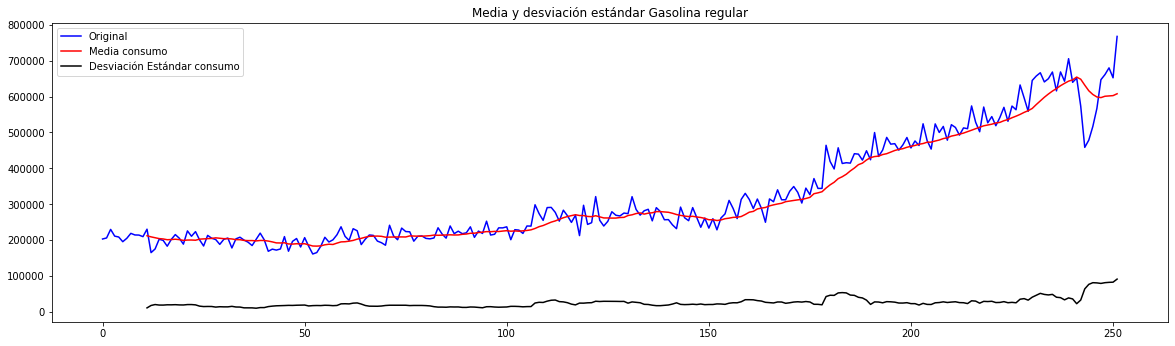

In [231]:
make_timeline(label_regular)

In [232]:
train_regular = train_df[['Fecha', label_regular]]
test_regular = test_df[['Fecha', label_regular]]

# Gasolina regular
train_regular[label_regular] = train_regular[label_regular].astype(float)
train_regular_indexed = train_regular.set_index(['Fecha'])

######### TEST ###############
# Gasolina regular
test_regular[label_regular] = test_regular[label_regular].astype(float)
test_regular_indexed = test_regular.set_index(['Fecha'])

In [233]:
# 2000-01-01 a 2019-12-01
removeCovid = 240
train_regular_indexed = train_regular_indexed[0:removeCovid]
train_regular_gas = train_regular_indexed[label_regular]

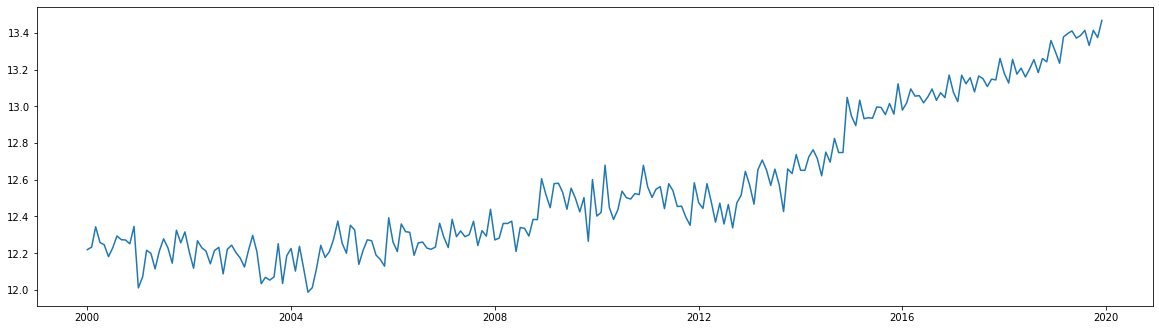

In [234]:
train_regular_log = np.log(train_regular_gas)
plt.plot(train_regular_log)

## Test de Dickey Fuller 

In [235]:
train_regular_gas_log_diff = train_regular_gas.diff()
train_regular_gas_log_diff.dropna(inplace=True)

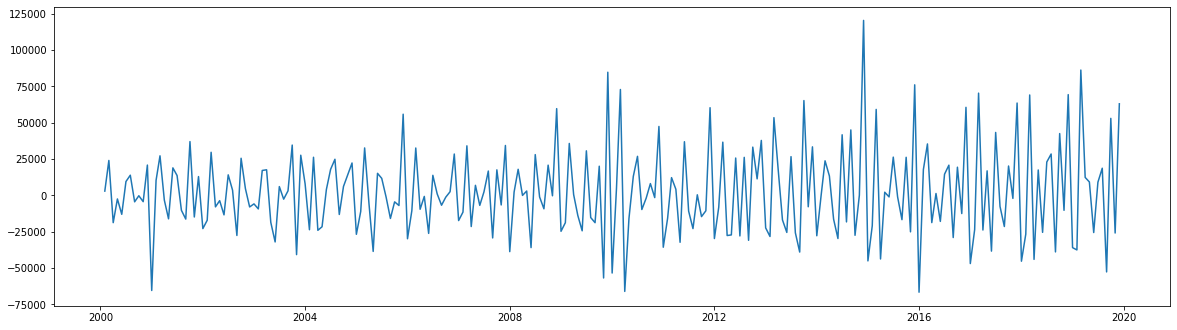

In [236]:
plt.plot(train_regular_gas_log_diff)

## Mejor modelo ARIMA 221

In [237]:
seasonalOrder = 3
if (dfToUse == "importacion"):
  seasonalOrder = 0

model_regular_121 = SARIMAX(
  train_regular_log,
  order=(1,2,1),
  seasonal_order=(seasonalOrder,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_regular_121 = model_regular_121.fit()
print(resultado_regular_121.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4416      0.062     -7.089      0.000      -0.564      -0.320
ma.L1         -1.0000    413.502     -0.002      0.998    -811.448     809.448
ar.S.L12      -0.7042      0.057    -12.461      0.000      -0.815      -0.593
ar.S.L24      -0.4608      0.078     -5.911      0.000      -0.614      -0.308
ar.S.L36      -0.2647      0.070     -3.799      0.000      -0.401      -0.128
sigma2         0.0047      1.928      0.002      0.998      -3.773       3.783


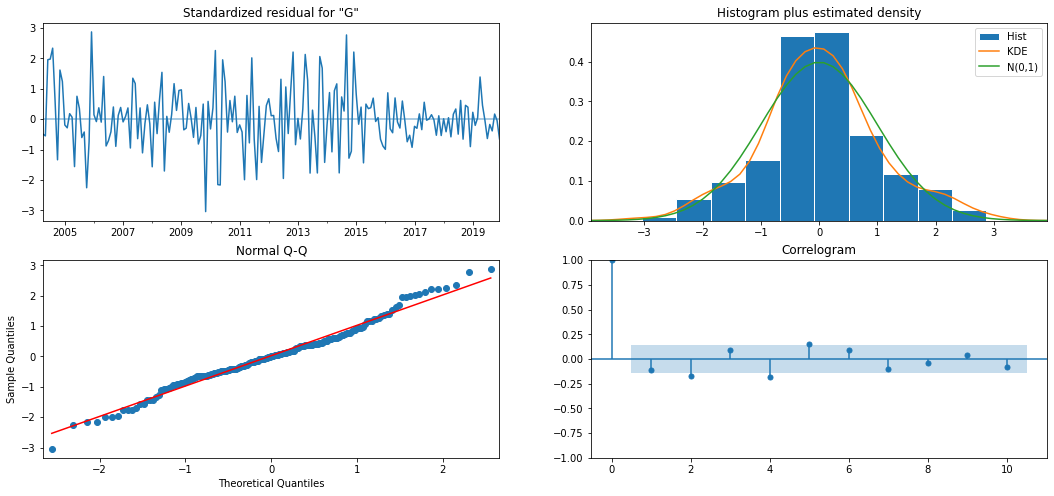

In [238]:
resultado_regular_121.plot_diagnostics(figsize=(18, 8))
plt.show()

## Prediccion

In [239]:
df_regular_indexed = df[['Fecha', label_regular]]
df_regular_indexed =  df_regular_indexed.set_index(['Fecha'])

In [240]:
def checkModel(prediction, test_indexed, label):
  pred = prediction.get_prediction(
    start=test_indexed.index[0],
    end=test_indexed.index[-1],
  ).summary_frame(alpha=0.05)

  fig, ax = plt.subplots(figsize=(15,5))
  test_log = np.log(test_indexed[label])
  ax = test_log.plot(label='Test Data')
  ax.set(
      title='True and Predicted Values, with Confidence Intervals',
      xlabel='Date',
      ylabel='Actual / Predicted Values'
  )

  pred['mean'].plot(ax=ax, style='r', label='Predicted Mean')
  ax.fill_between(
      pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'],
      color='r', alpha=0.1
  )
  legend = ax.legend(loc='upper left')
  plt.show()

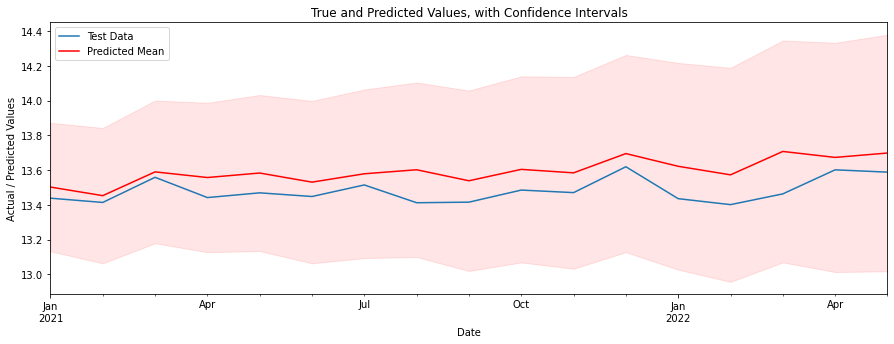

In [241]:
checkModel(resultado_regular_121, test_regular_indexed, label_regular)

# LSTM


In [242]:
tf.random.set_seed(123)

### Test de Dickey Fuller

In [243]:
indexed_df = df.set_index(['Fecha'])

In [244]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(indexed_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.978680
p-value                        1.000000
# de retardos usados          15.000000
# de observaciones usadas    253.000000
Critical Value (1%)           -3.456464
Critical Value (5%)           -2.873033
Critical Value (10%)          -2.572895
dtype: float64


In [245]:
regular_diff = indexed_df.diff()
regular_diff.fillna(0,inplace=True)
dfTest = adfuller(regular_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Estadístico de prueba         -4.069477
p-value                        0.001087
# de retardos usados          16.000000
# de observaciones usadas    252.000000
Critical Value (1%)           -3.456569
Critical Value (5%)           -2.873079
Critical Value (10%)          -2.572919
dtype: float64


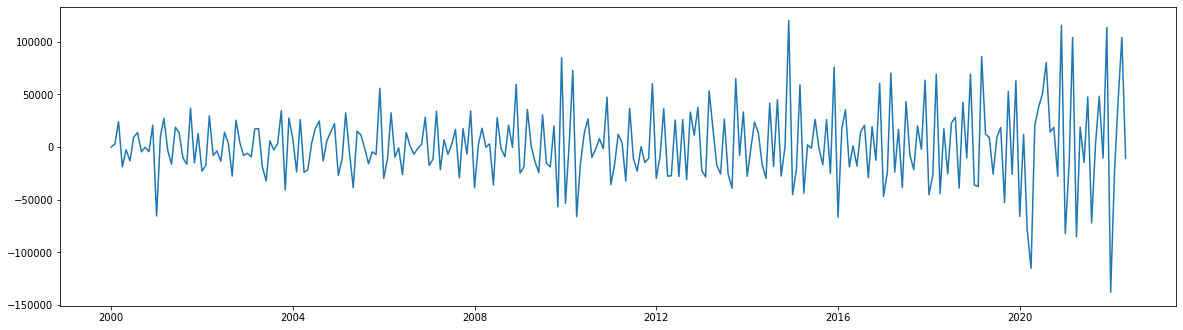

In [246]:
plt.plot(regular_diff)

### Normalizando la serie

In [247]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff) 
regular_diff_scaled[1:7]

array([[ 0.01880451],
       [ 0.60444086],
       [-0.5841119 ],
       [-0.13124654],
       [-0.42456805],
       [ 0.20164594]])

### Separando train y test

In [248]:
entrenamiento = round(0.6*len(regular_diff_scaled))
val_prueba = round(0.2*len(regular_diff_scaled))
test = regular_diff_scaled[(entrenamiento+val_prueba)-1:]
validation = regular_diff_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = regular_diff_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
print(len(train), len(test), len(validation))

162 55 55


### Serie supervisada

In [249]:
# Corriendo los valores una posicion
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)




### Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

In [257]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

54

In [258]:
def createModel(lote, paso, caracteristicas=1, dense=1):
    modelo = Sequential()
    modelo.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
    modelo.add(Dense(dense))
    modelo.summary()
    
    modelo.compile(loss='mean_squared_error',optimizer="rmsprop")

    return modelo


def graphLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')

def showLoss(modelo):
    print("Pérdida en Entrenamiento")
    modelo.evaluate(
        x = x_train,
        y = y_train
    )
    print("Pérdida en Validación")
    modelo.evaluate(
        x = x_val,
        y = y_val
    )
    print("Pérdida en Prueba")
    modelo.evaluate(
        x = x_test,
        y = y_test
    )

In [269]:
def modelToUse(index):
    if index == 1:
        return [1, 1, 50, 1]
    else:
        return [1, 1, 100, 4]

lote, paso, epocas, dense = modelToUse(2)
model = createModel(lote, paso, dense=dense)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (1, 1)                    12        
                                                                 
 dense_19 (Dense)            (1, 4)                    8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


### Entrenando el modelo

In [270]:
history= model.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/100
161/161 [==============================] - 2s 4ms/step - loss: 0.4804 - val_loss: 1.0385
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4739 - val_loss: 1.0274
Epoch 3/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4671 - val_loss: 1.0153
Epoch 4/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4600 - val_loss: 1.0025
Epoch 5/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4527 - val_loss: 0.9895
Epoch 6/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4454 - val_loss: 0.9765
Epoch 7/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4382 - val_loss: 0.9640
Epoch 8/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4311 - val_loss: 0.9523
Epoch 9/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4243 - val_loss: 0.9416
Epoch 10/100
161/161 [==============================] - 0s 2ms/step - loss: 0.4180 - val_lo

El modelo 1 parece estancarse en la epoca 40

El modelo 2 parece estancarse en la epoca 88

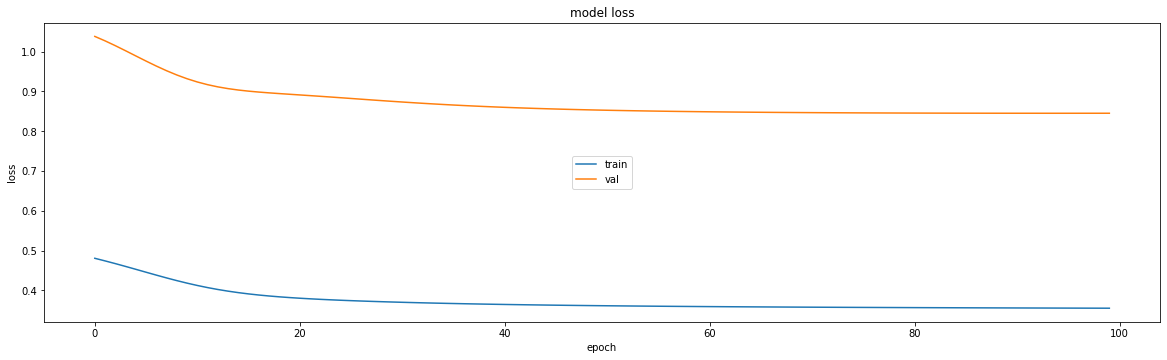

In [271]:
graphLoss(history)

In [272]:
showLoss(modelo1)

Pérdida en Entrenamiento
6/6 [==============================] - 0s 1ms/step - loss: 0.4896
Pérdida en Validación
2/2 [==============================] - 0s 2ms/step - loss: 1.0759
Pérdida en Prueba
2/2 [==============================] - 0s 2ms/step - loss: 2.5096


### Prediccion

In [273]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series=None, n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [274]:
prediccion_val = []

prediccion_val = prediccion_fun(x_val,model, 1,scaler,dif=True,dif_cant=1, Series = indexed_df.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,model, 1,scaler,dif=True,dif_cant=1, Series = indexed_df.values , n=entrenamiento+val_prueba)

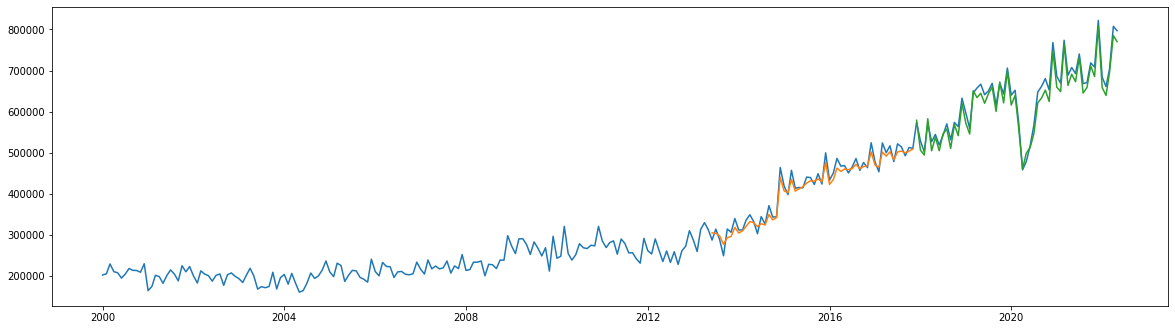

In [275]:
df_val = pd.DataFrame(prediccion_val,index=indexed_df[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=indexed_df[entrenamiento+len(df_val):len(indexed_df)].index)


plt.plot(indexed_df)
plt.plot(df_val)
plt.plot(df_test)

